FastTrackPy smooths formant trajectories using a form of Discrete Cosine Transform. Here's how you can convert the DCT parameters back into formant track smooths after, e.g. averaging them.

In [1]:
import polars as pl
import matplotlib.pyplot as plt
from scipy.fft import dct, idct
import numpy as np
from fasttrackpy import process_corpus
from pathlib import Path

In [2]:
corpus_path = Path("..","assets", "corpus")
measurements = process_corpus(corpus_path)

100%|██████████| 274/274 [00:01<00:00, 224.56it/s]


Let's just look at /ay/ from these speakers.

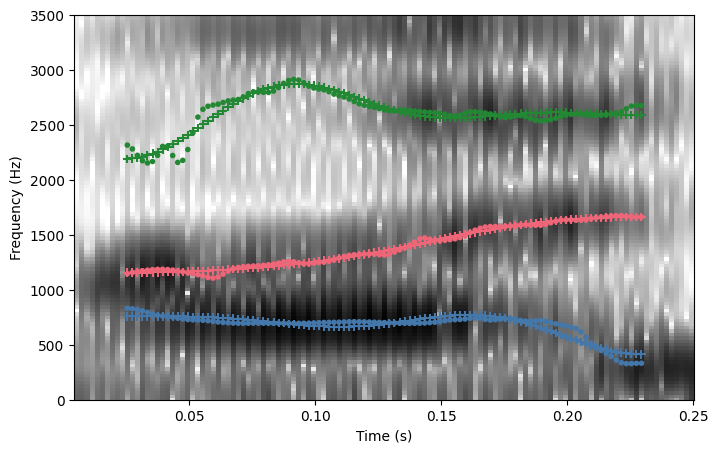

In [3]:
ays = [track for track in measurements if track.label == "AY1"]
ays[0].winner.spectrogram()

## The Discrete Cosine Transform

The smoothed formants are a 5th order discrete cosine transform. The DCT parameters are estimated via regression, using the following basis.

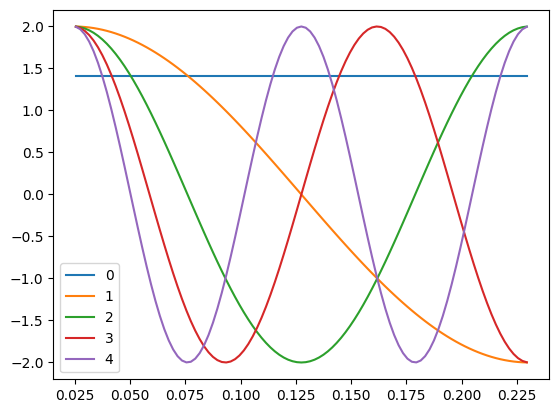

In [4]:
time = ays[0].winner.time_domain
N = time.size
order = 5

full_basis = dct(
    np.eye(N), 
    orthogonalize=True, 
    norm = "backward"
)

basis = full_basis[:,:order]

plt.plot(time, basis)
plt.legend(range(5))
plt.show()

DCT coefficients define how to weight and sum this bank of cosine functions to match the input signal.

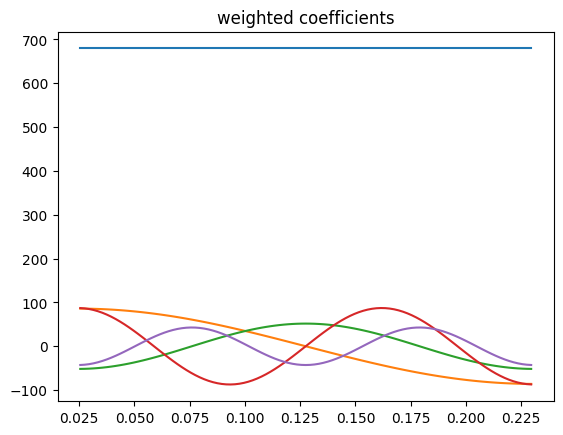

In [5]:
# the dct coefs for f1
f1_params = ays[0].winner.parameters[0,:]

# the formant track
f1 = ays[0].winner.formants[0,:]

plt.plot(time, basis * f1_params)
plt.title("weighted coefficients")
plt.show()

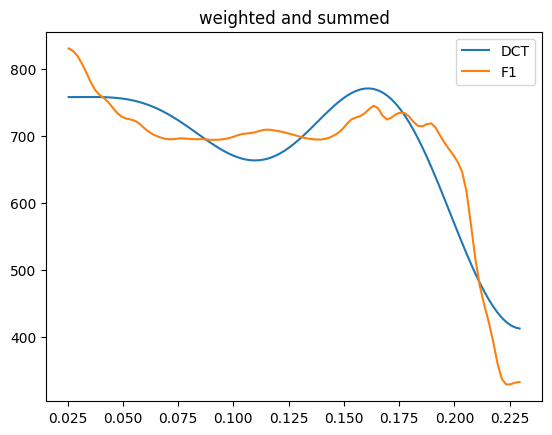

In [6]:
plt.plot(time, basis @ f1_params)
plt.plot(time, f1)
plt.title("weighted and summed")
plt.legend(["DCT", "F1"])
plt.show()

It's possible to estimate DCT coefficients directly with `scipy.fft.dct`, but because there is potential for missing data in some formant tracks, FastTrackPy instead estimates the DCT coefficients using regression.

In [7]:
def reg_fit(x, basis):
    params = np.linalg.inv(basis.T @ basis) @ (basis.T @ x)
    return params

params = reg_fit(f1, basis)
print(params)

[480.35423508  42.95237019 -25.847216    43.60350087 -21.40266949]


## Inverting the DCT

It's possible to invert the DCT parameters with `scipy.fft.idct()`, with `orthognalize = True` and `norm = "forward"`. You also need to define how large you want the resulting smooth to be with `n`

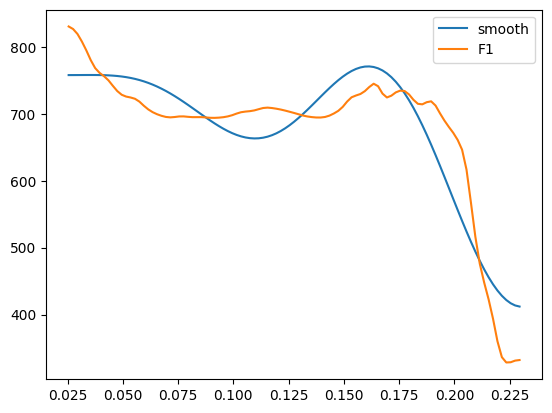

In [8]:
f1_smooth = idct(
    params, 
    n = time.size, 
    orthogonalize=True, 
    norm = "forward"
    )

plt.plot(time, f1_smooth)
plt.plot(time, f1)
plt.legend(["smooth", "F1"])
plt.show()

## Benefits of using the DCT parameters

### "Down sampling"

It's somewhat commmon to reduce the number of measurement points from a formant track to a common number (e.g. 20 evenly spaced points). We can achieve that by inverting the DCT parameters and using differently sized outputs.

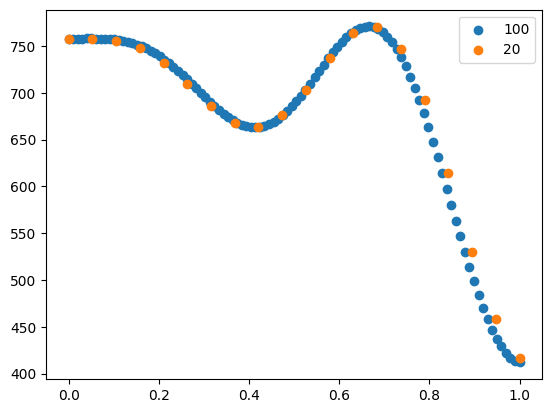

In [9]:
smooth_100 = idct(params, n = 100, orthogonalize=True, norm = "forward")
smooth_20 = idct(params, n = 20, orthogonalize=True, norm = "forward")

plt.scatter(
    np.arange(100)/99,
    smooth_100
)

plt.scatter(
    np.arange(20)/19,
    smooth_20
)
plt.legend(["100", "20"])
plt.show()

### Averaging

Instead of point-wise averaging over formant tracks, you can instead average over the DCT parameters, then invert the average. We can get a polars data frame of all of the parameters of /ays/ from these speakers with the `.to_df()` method,

In [10]:
all_ay_param = pl.concat([
    ay.to_df(output = "param")
    for ay in ays
])
all_ay_param.head()

param,F1,F2,F3,F4,error,file_name,id,group,label
u32,f64,f64,f64,f64,f64,str,str,str,str
0,480.354235,979.982402,1844.645657,2375.309331,0.007663,"""KY25A_1""","""0-0-8-1""","""KY25A""","""AY1"""
1,42.95237,-130.966974,-15.909405,2.074594,0.007663,"""KY25A_1""","""0-0-8-1""","""KY25A""","""AY1"""
2,-25.847216,13.467448,-67.211033,-35.364144,0.007663,"""KY25A_1""","""0-0-8-1""","""KY25A""","""AY1"""
3,43.603501,4.180242,-84.055828,18.796364,0.007663,"""KY25A_1""","""0-0-8-1""","""KY25A""","""AY1"""
4,-21.402669,-2.113492,-42.2589,-20.556695,0.007663,"""KY25A_1""","""0-0-8-1""","""KY25A""","""AY1"""


To get the the average of each parameter for each speaker, we need to group the dataframe by the `param`, `file_name` and `group` columns, then aggregate them.

In [11]:
ay_param_means = (all_ay_param
 .group_by(
     ["param", "file_name", "group", ], 
     maintain_order = True)
 .agg(
     pl.col("F1").mean()
 )
)
ay_param_means.head()

param,file_name,group,F1
u32,str,str,f64
0,"""KY25A_1""","""KY25A""",509.370491
1,"""KY25A_1""","""KY25A""",44.866749
2,"""KY25A_1""","""KY25A""",-8.803074
3,"""KY25A_1""","""KY25A""",27.038315
4,"""KY25A_1""","""KY25A""",-11.637004


Here's the fitted F1 for the first speaker.

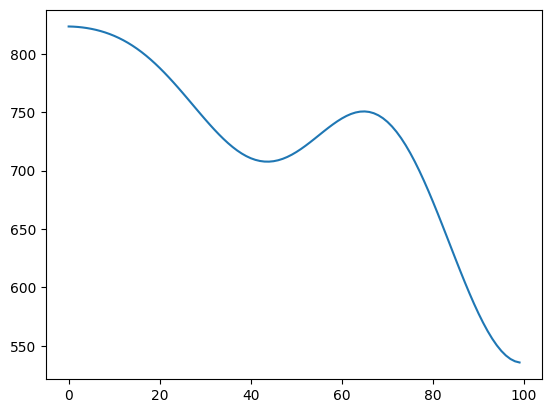

In [12]:
speaker_params = ay_param_means["F1"][0:5]
speaker_fit = idct(
    speaker_params,
    n = 100,
    orthogonalize=True,
    norm="forward"
)

plt.plot(speaker_fit)
plt.show()

The code below for getting fitted F1 tracks for each speaker is a bit detailed with respect to how polars dataframes work, but the process could be replicated in whatever way a user feels comfortable.

In [13]:
ay_fits = (
    ay_param_means
    .group_by(["file_name", "group"])
    .agg(pl.col("F1"))
    .with_columns(
        f1_fit =pl.col("F1")
                  .map_elements(
                      lambda x: idct(x, n = 100, orthogonalize=True, norm = "forward").tolist(),
                      return_dtype=pl.List(pl.Float64)
                      ),
        time = pl.lit(np.linspace(0,1,100).tolist())
    )
    .explode(["f1_fit", "time"])
)

In [14]:
ay_fits.plot(
    "time",
    "f1_fit",
    by = "group"
)

:NdOverlay   [group]
   :Curve   [time]   (f1_fit)

### Getting derivatives

If we wanted to get the first derivative (or the rate of change) of the formant track smooths, this can also be calculated (code modified from [here](https://stackoverflow.com/questions/57675927/how-to-calculate-spectral-derivative-using-scipy-fftpack-dst-dct).)

In [15]:
from scipy.fft import idst

def first_deriv(coefs, size = 100):
    hatu = coefs.copy()
    for i in range(hatu.size):
        hatu[i]=-(i)*hatu[i]
    hatu[:-1]=hatu[1:]
    hatu[-1]=0
    dotu=idst(hatu, n = size, type=2)
    return dotu

In [16]:
speaker_fit = (
    ay_fits
    .filter(pl.col("group").str.contains("group"))
)

speaker_params = (
    ay_param_means
    .filter(pl.col("group").str.contains("group"))
    .select("F1")
)

speaker_rate = first_deriv(speaker_params["F1"].to_numpy(), size = 100)

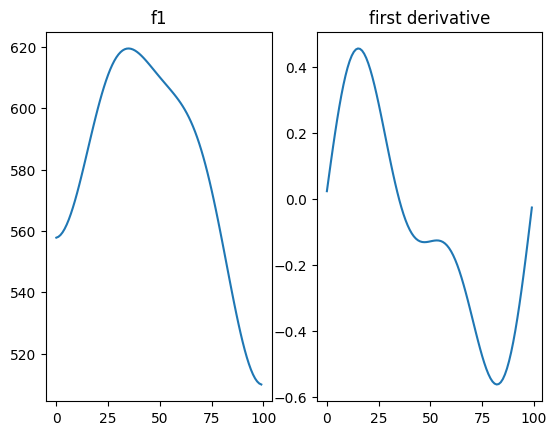

In [17]:
fig, axes = plt.subplots(nrows= 1, ncols=2)
axes[0].plot(speaker_fit["f1_fit"])
axes[0].set_title("f1")
axes[1].plot(speaker_rate)
axes[1].set_title("first derivative")
plt.show()